# part0: imports

In [1]:
%matplotlib inline


import os, sys, pathlib
from pprint import pprint
import gc
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)

import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
import scipy.linalg as linalg
import scipy.stats as stats
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, r2_score
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from matplotlib.ticker import MaxNLocator

import torch

import pyaldata as pyal

try:
    nbPath = pathlib.Path.cwd()
    RepoPath = nbPath.parent
    os.chdir(RepoPath)

    from tools import utilityTools as utility
    from tools import dataTools as dt
    from tools import lstm
    import params
    defs = params.monkey_defs
    monkey_defs = defs
    
    set_rc =  params.set_rc_params
    set_rc()
    root = params.root
    reload(params)
    reload(defs)

finally:
    os.chdir(nbPath)

if "__file__" not in dir():

    %run "_dataset-selection.ipynb"

# Read data

In [2]:
full_list = []
for animal, sessionList in GoodDataList[defs.areas[2]].items():
    if 'Mr' in animal:
        continue  # to remove MrT
    full_list.append((animal,sessionList))
full_list = [(animal,session) for animal,sessions in full_list for session in set(sessions)]

# load the DFs
warnings.filterwarnings("ignore")
allDFs = []
for animal, session in full_list:
    path = root/animal/session
    allDFs.append(defs.prep_general(dt.load_pyal_data(path)))
warnings.filterwarnings("default")


## Decoding performance with different dimensionalities

---
For the example sessions

In [3]:
def monkey_decoding_fix_D(allDFs, custom_r2_func, n_dim = 10):
    
    defs = monkey_defs


    within_score = {}
    aligned_score = {}
    unaligned_score = {}
    for i, df1 in enumerate(tqdm(allDFs)):
        AllData, AllVel = defs.get_data_array_and_vel([df1], defs.exec_epoch_decode,
                                                    area=defs.areas[2], n_components=n_dim)
        # adding history
        AllData = dt.add_history_to_data_array(AllData,defs.MAX_HISTORY)
        AllData = AllData[...,defs.MAX_HISTORY:,:]
        AllVel = AllVel[...,defs.MAX_HISTORY:,:]
        AllData1 = AllData[0,...]
        AllVel1 = AllVel[0,...]
        *_,n_time,n_comp = AllData1.shape
        # resizing
        X1 = AllData1.reshape((-1,n_time,n_comp))
        AllVel1 = AllVel1.reshape((-1,n_time,2))
        
        fold_score =[]
        kf = KFold(n_splits=10)
        for train_index, test_index in kf.split(X1[:,0,0]):
            x_train, x_test = X1[train_index,...], X1[test_index,...]
            y_train, y_test = AllVel1[train_index,...], AllVel1[test_index,...]

            lstm_model = lstm.LSTMDecoder(input_dims=X1.shape[-1], output_dims=2)
            lstm_model.fit(x_train=x_train, y_train=y_train)
            pred, label = lstm_model.predict(x_test, y_test)
            fold_score.append(custom_r2_func(pred, label))
        fold_score = np.median(fold_score)
        within_score[df1.session[0]] = fold_score

        aligned_score[df1.session[0]] = {}
        unaligned_score[df1.session[0]] = {}
        for j, df2 in enumerate(tqdm(allDFs)):
            if j <= i: continue
            if df1.monkey[0] == df2.monkey[0]: continue
            if 'Chewie' in df1.monkey[0] and 'Chewie' in df2.monkey[0]: continue

            AllData, AllVel = defs.get_data_array_and_vel([df1,df2],
                                                        defs.exec_epoch_decode, area=defs.areas[2], n_components=n_dim)
            # adding history
            AllData = dt.add_history_to_data_array(AllData,defs.MAX_HISTORY)
            AllData = AllData[...,defs.MAX_HISTORY:,:]
            AllVel = AllVel[...,defs.MAX_HISTORY:,:]

            AllData1 = AllData[0,...]
            AllData2 = AllData[1,...]
            AllVel1 = AllVel[0,...]
            AllVel2 = AllVel[1,...]
            # resizing
            *_,n_time,n_comp = AllData1.shape

            X1 = AllData1.reshape((-1,n_comp))
            X2 = AllData2.reshape((-1,n_comp))
            AllVel2 = AllVel2.reshape((-1,n_time,2))
            AllVel1 = AllVel1.reshape((-1,n_time,2))

            # train the aligned
            *_,U,V = dt.canoncorr(X1, X2, fullReturn=True)
            U = U.reshape((-1,n_time,n_comp))
            V = V.reshape((-1,n_time,n_comp))
            X1 = X1.reshape((-1,n_time,n_comp))
            X2 = X2.reshape((-1,n_time,n_comp))

            lstm_model = lstm.LSTMDecoder(input_dims=U.shape[-1], output_dims=2)
            lstm_model.fit(x_train=U, y_train=AllVel1)
            pred, label = lstm_model.predict(V, AllVel2)
            aligned_score[df1.session[0]][df2.session[0]]=custom_r2_func(pred, label).mean()
            #================================
            # Unaligned
            lstm_model = lstm.LSTMDecoder(input_dims=U.shape[-1], output_dims=2)
            lstm_model.fit(x_train=X1, y_train=AllVel1)
            pred, label = lstm_model.predict(X2, AllVel2)
            unaligned_score[df1.session[0]][df2.session[0]]=custom_r2_func(pred, label).mean()

    return within_score, aligned_score, unaligned_score

def run_decode_var_D(allDFs, custom_r2_func, dim_range=None, redo=False):
    if dim_range is None:
        dim_range = range(1, defs.n_components + 5)

    pop_within = []
    pop_aligned = []
    pop_unaligned = []
    for dim in dim_range:
        pathPickle = root / 'monkey-pickles' / f'D{dim}_decode_{custom_r2_func.__name__}.p'
        if os.path.exists(pathPickle) and not redo:
            with open(pathPickle,"rb") as f:
                within_score, aligned_score, unaligned_score = pickle.load(f)
        else:
            within_score, aligned_score, unaligned_score = monkey_decoding_fix_D(allDFs, custom_r2_func, n_dim = dim)
            with open(pathPickle, 'wb') as f:
                pickle.dump([within_score, aligned_score, unaligned_score], f)
                f.close()

        pop_within.append(np.array(list(within_score.values())))
        pop_aligned.append(np.array([val for key in aligned_score for val in aligned_score[key].values()]))
        pop_unaligned.append(np.array([val for key in unaligned_score for val in unaligned_score[key].values()]))

    pop_within = np.array(pop_within)
    pop_aligned = np.array(pop_aligned)
    pop_unaligned = np.array(pop_unaligned)

    return pop_within, pop_aligned, pop_unaligned

---

## running it for all the sessions

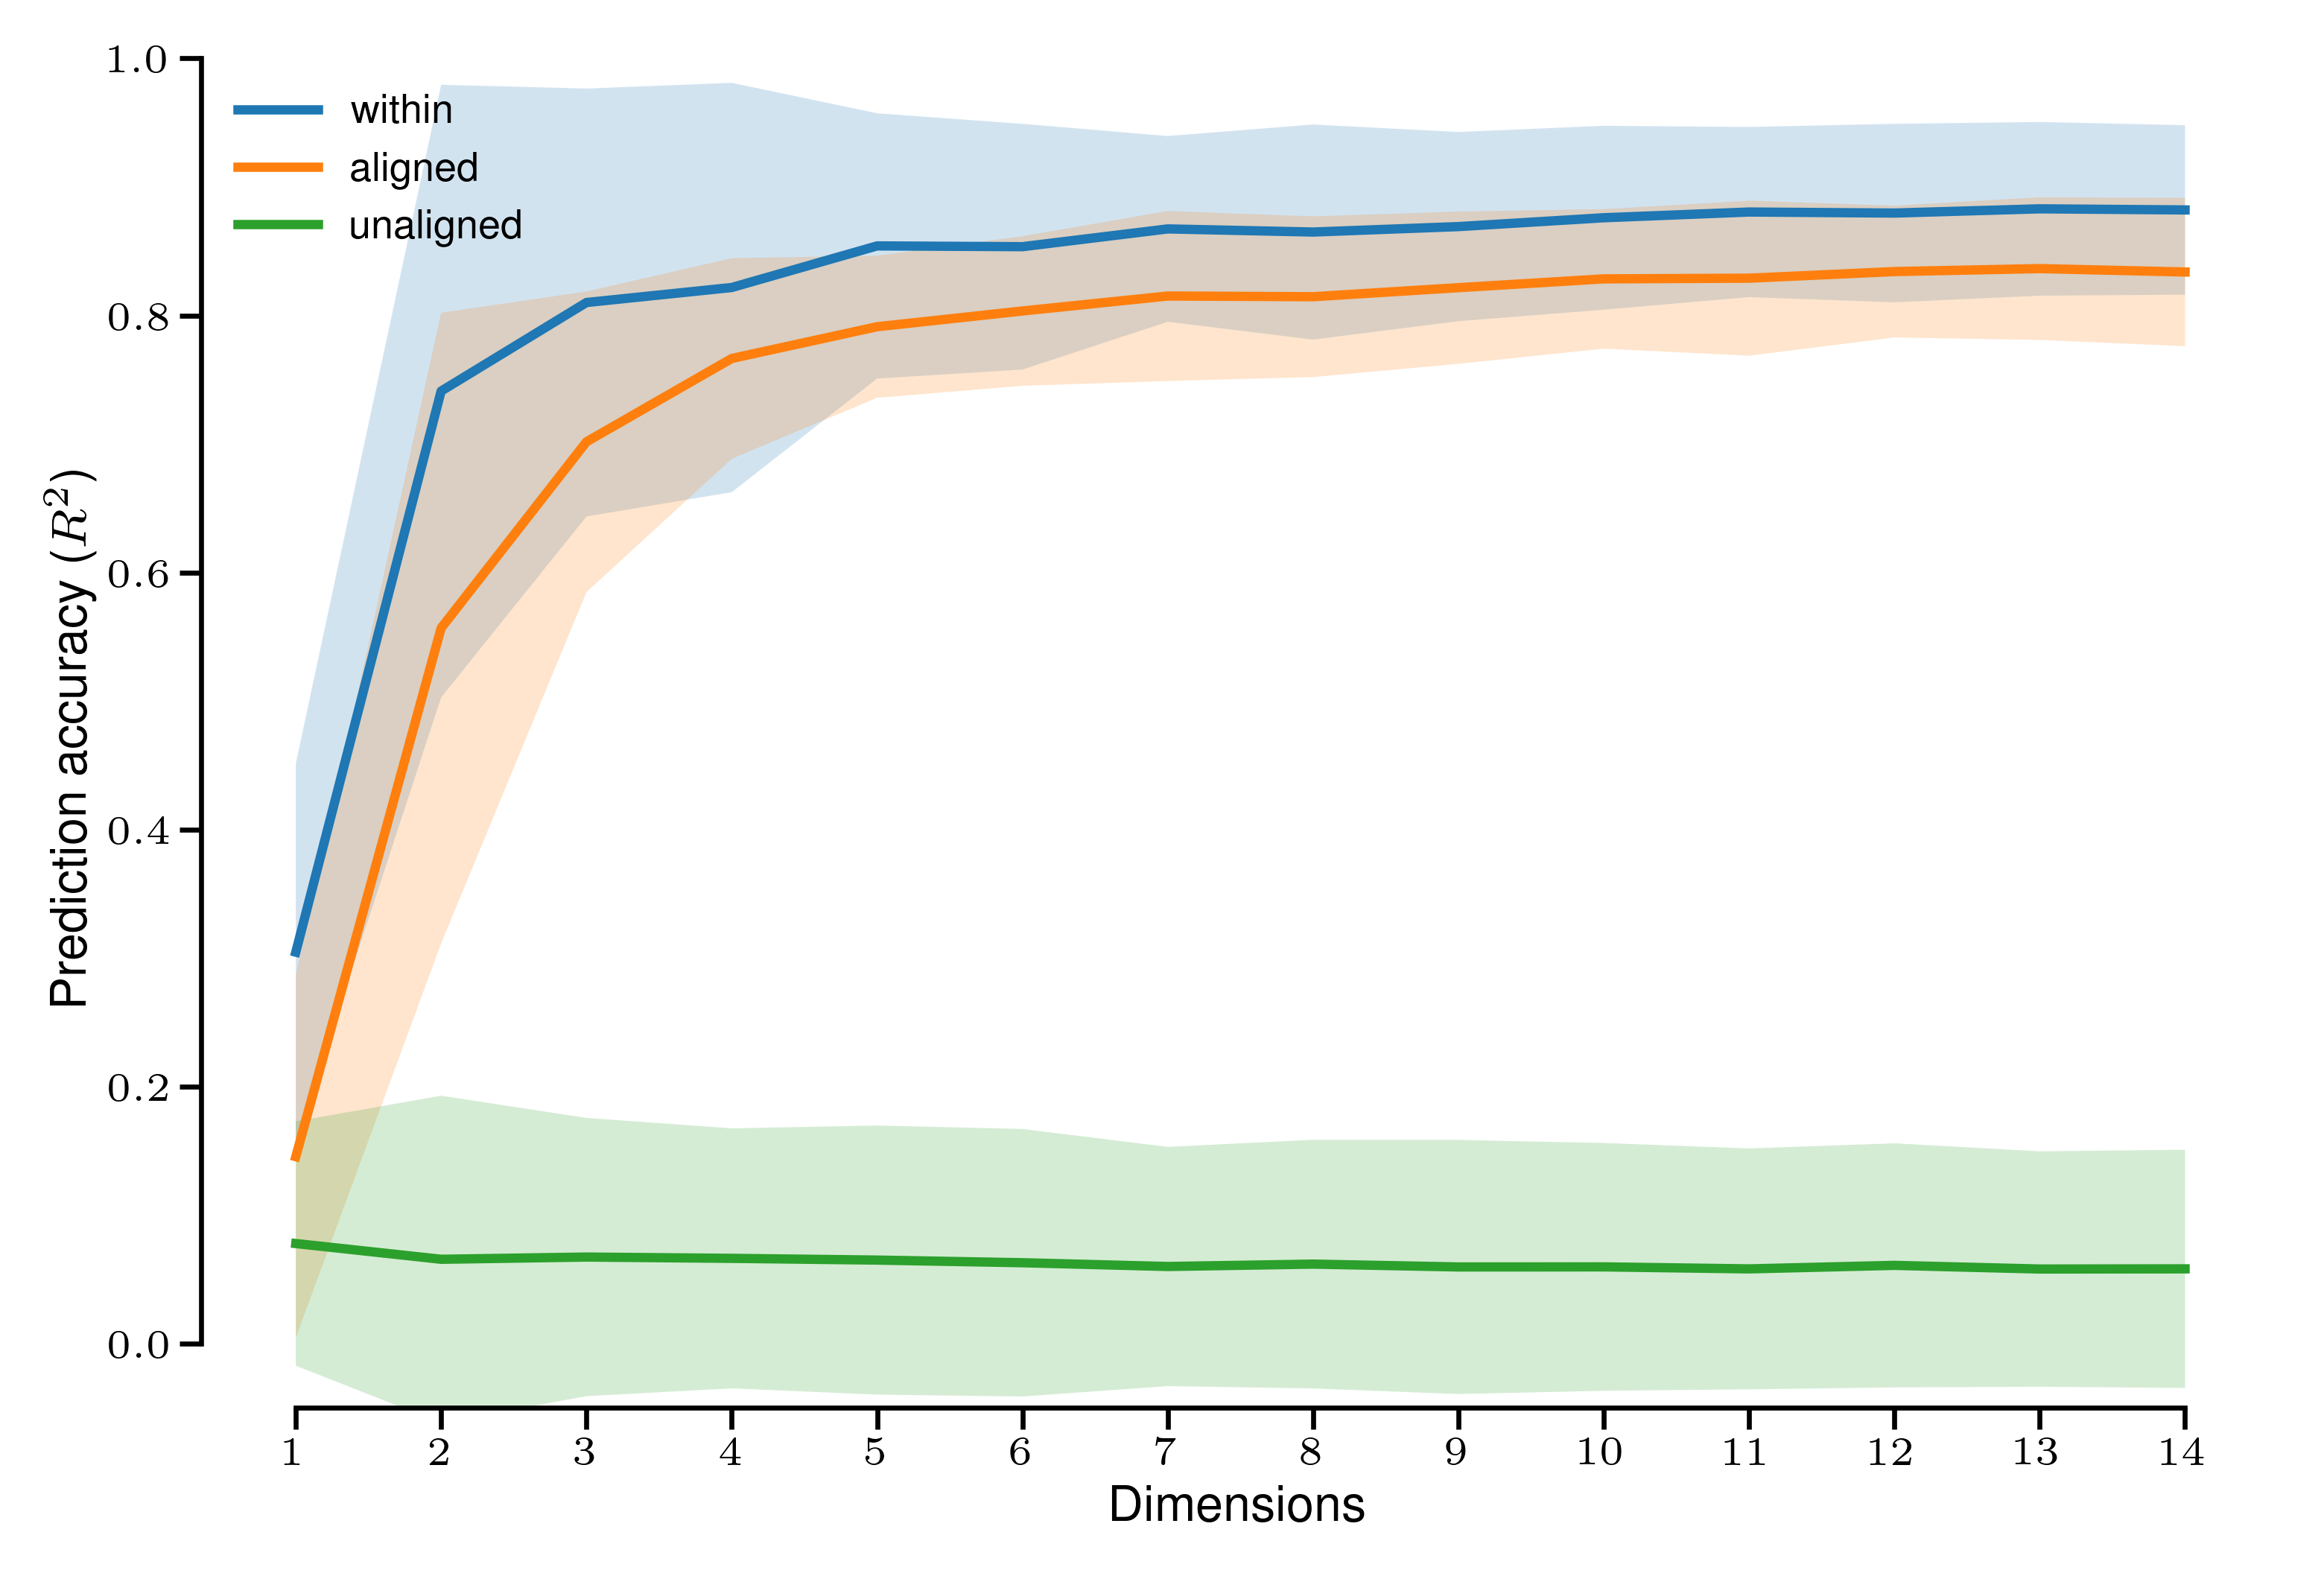

In [4]:
dim_range = range(1, defs.n_components + 5)

plt.close('all')
set_rc()
fig, ax = plt.subplots(1,1)  

pop_within, pop_aligned, pop_unaligned = run_decode_var_D(allDFs, lstm.custom_r2_func, dim_range=dim_range, redo=False)

utility.shaded_errorbar(ax,list(range(1, defs.n_components + 5)), pop_within, label='within')
utility.shaded_errorbar(ax,list(range(1, defs.n_components + 5)), pop_aligned, label='aligned')
utility.shaded_errorbar(ax,list(range(1, defs.n_components + 5)), pop_unaligned, label='unaligned')
ax.legend()

ax.set_ylabel('Prediction accuracy ($R^2$)')
ax.set_xlabel('Dimensions')
ax.set_ylim([-.05,1])
ax.set_xticks(list(range(1, defs.n_components + 5)))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_bounds([0,1])
ax.spines['bottom'].set_bounds([1,14])

fig.savefig(params.figPath / 'decoding-var-dim.pdf', format='pdf', bbox_inches='tight')
plt.show()